### 1.生成画像の取得

In [1]:
from models.DCmodel import ACGenerator, CGenerator
from options import get_parser
from mylib import *
import word2vec
import torch
import random
from dataset import *
import numpy as np
import torch.nn as nn

In [2]:
Cmodel_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/CGAN/model_100'
ACmodel_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/ACGAN/model_50'
CPmodel_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/CPGAN/model_50'
Imp2Font_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/Imp2Font/model_35r'
parser = get_parser()
opts = parser.parse_args(args=[])
data = np.array([np.load(d) for d in opts.data])
Embedding_model = word2vec.word2vec()
weights = Embedding_model.vectors
ID = {}
c = 1
mask = []
for idx, key in enumerate(Embedding_model.vocab.keys()):
    if key in opts.w2v_vocab.keys():
        ID[key] = c
        c += 1
        mask.append(idx)
    else:
        continue

Embedding　OK


In [3]:
SEED = 1111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device ='cuda'

In [4]:
G_model = ACGenerator(weights, mask, z_dim=300, char_num=26, mode = 'CP', emb = 'w2v').to('cuda')
G_model = nn.DataParallel(G_model)
G_model.load_state_dict(torch.load(Imp2Font_path)["G_model_state_dict"], strict=False)
G_model.eval()

DataParallel(
  (module): ACGenerator(
    (w2v_layer): ImpEmbedding(
      (embed): Embedding(1574, 300)
      (fc): Sequential(
        (0): Linear(in_features=1574, out_features=1, bias=True)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (res_block): Sequential()
    )
    (layer1): Sequential(
      (0): Linear(in_features=326, out_features=1500, bias=True)
      (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer2): Sequential(
      (0): Linear(in_features=300, out_features=1500, bias=True)
      (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer3): Sequential(
      (0): Linear(in_features=3000, out_features=32768, bias=True)
      (1): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5,

### １．印象語からの画像生成

In [6]:
generate_num = 4
aaa = torch.tensor([0, 1, 2, 7, 4, 17, 14, 13, 18])
char_num = len(aaa)
char_class = torch.eye(26)[aaa].repeat(generate_num, 1)
noise = torch.normal(mean = 0.5, std = 0.2, size = (generate_num, 300))
noise = tile(noise, 0, char_num).to(device)

['traditional', 'classical', 'modern', 'orthodox', 'contemporary', 'oriental', 'alternative']
torch.Size([36, 300]) torch.Size([36, 1574]) torch.Size([36, 26])


<ipython-input-8-5c57c2f20867>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).repeat(char_num * generate_num, 1).to(device)


['banner', 'flag', 'billboard', 'poster', 'logo', 'caption', 'lettering']
torch.Size([36, 300]) torch.Size([36, 1574]) torch.Size([36, 26])


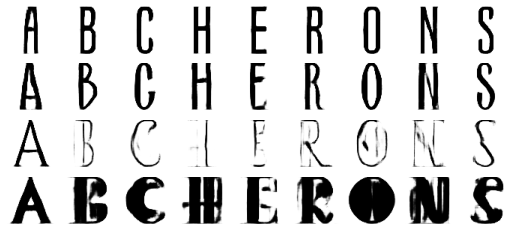

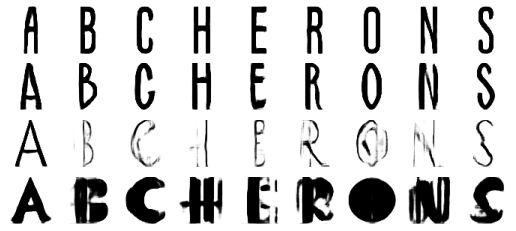

In [8]:
#label = Embedding_model['shading']
word_list =[['traditional'], ['banner']] 
for word in word_list:
    similar = list(Embedding_model.most_similar(positive=word, topn=100))
    similar = word + [i[0] for i in similar if i[0] in ID.keys()]
    print(similar)
    label = [[ID[token] for token in word]]
    label = Multilabel_OneHot(label, len(ID), normalize = True)
    label = torch.tensor(label).repeat(char_num * generate_num, 1).to(device)
    print(noise.shape, label.shape, char_class.shape)
    with torch.no_grad():
        samples = G_model(noise, label, char_class)
        samples = samples.data.cpu()
        samples = (samples/2)+0.5  
    row = generate_num
    col = char_num
    plt.figure(figsize=(char_num * 1 , generate_num*1))
    num = 0
    while num < row * col:
        num += 1
        plt.subplot(row, col, num)
        plt.imshow(np.squeeze(samples[num-1]), cmap = "gray")
        plt.axis('off')
    plt.savefig(os.path.join('/home/matsuda/google-drive/ICDAR_figs/gen_fonts_single','CP_{}.png'.format('+'.join(word))))

In [9]:
generate_num = 4
aaa = torch.tensor([0, 1, 2, 7, 4, 17, 14, 13, 18])
char_num = len(aaa)
char_class = torch.eye(26)[aaa].repeat(generate_num, 1)
noise = torch.normal(mean = 0.5, std = 0.2, size = (generate_num, 300))
noise = tile(noise, 0, char_num).to(device)

torch.Size([36, 1574, 300]) torch.Size([36, 300]) torch.Size([36, 26])


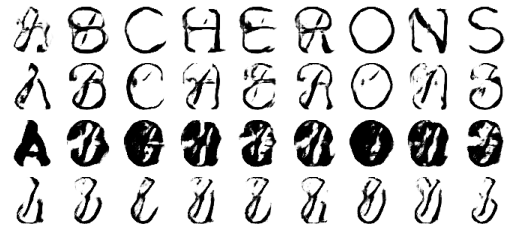

In [11]:
condition = torch.cat([torch.tensor(Embedding_model['pear']).unsqueeze(0), torch.zeros(1573, 300)], dim=0)
condition = condition.repeat(generate_num * char_num, 1, 1)
with torch.no_grad():
    print(condition.size(), noise.size(), char_class.size())
    samples = G_model(noise, condition, char_class, w2v=False)
    samples = samples.data.cpu()
    samples = (samples/2)+0.5  
row = generate_num
col = char_num
plt.figure(figsize=(char_num * 1 , generate_num*1))
num = 0
while num < row * col:
    num += 1
    plt.subplot(row, col, num)
    plt.imshow(np.squeeze(samples[num-1]), cmap = "gray")
    plt.axis('off')

In [12]:
word = 'apple'
similar = list(Embedding_model.most_similar(positive=word, topn=100))
print([i[0] for i in similar if i[0] not in ID.keys()])
ID[word]

['apples', 'pear', 'berry', 'pears', 'strawberry', 'peach', 'potato', 'grape', 'blueberry', 'cherries', 'mango', 'apricot', 'melon', 'almond', 'Granny_Smiths', 'grapes', 'peaches', 'pumpkin', 'apricots', 'berries', 'tomato', 'honeycrisp', 'mango_tango', 'apple_pear', 'Granny_Smith', 'strawberries', 'loquat', 'grapefruit', 'Newtown_Pippin', 'kumquats', 'kiwi_fruit', 'raspberries', 'watermelon', 'apples_ripen', 'pear_varieties', 'crumb_pie', 'apple_varieties', 'orchard', 'Jonagold', 'Honeycrisp_apples', 'cherry', 'olive', 'muskmelon', 'Apples', 'Fuji_apple', 'satsuma', 'banana', 'seedless_watermelon', 'tree_ripened', 'nectarine', 'rhubarb', 'Red_Delicious', 'pippin', 'heirloom_tomato', 'blackberries', 'hazelnut', 'Delicious_apple', 'Honey_Crisp', 'persimmons', 'macadamias', 'oranges', 'apple_orchard', 'cherimoyas', 'juicy_peach', 'peach_nectarine', 'bing_cherries', 'asparagus', 'juicy_peaches', 'onion', 'jujubes', 'pawpaw', 'ripened_fruits', 'pistachio', 'blueberries_raspberries', 'ripe_

865

# semantic Generation

In [13]:
#label = Embedding_model['shading']
import PIL.ImageDraw
from PIL import Image
import PIL.ImageFont
imgs = []
fontsize = 36
font_name = "/home/matsuda/デスクトップ/Imp2Font/Fun.ttf"
font = PIL.ImageFont.truetype(font_name, fontsize)
canvasSize    = (300, 150)
backgroundRGB = (255, 255, 255)
textRGB       = (0, 0, 0)
for text in similar:
    img  = PIL.Image.new('RGB', (64, 64))
    draw = PIL.ImageDraw.Draw(img)
    textWidth, textHeight = draw.textsize(text, font=font)
    textTopLeft = (canvasSize[0]//6, canvasSize[1]//2-textHeight//2) # 前から1/6，上下中央に配置
    draw.text(textTopLeft, text, fill=textRGB, font=font)
    imgs.append((np.asanyarray(img)/2) + 0.5)
char_class = torch.eye(26).repeat(len(similar),1)
noise = torch.normal(mean = 0.5, std = 0.2, size = (1, 300)).repeat(len(similar) * 26,1).to(device)
label = [[ID[token]] for token in similar]
label = Multilabel_OneHot(label, len(ID), normalize = True)
label = tile(torch.tensor(label), 0, 26).clone().detach()
print(char_class.size(), noise.size(), label.size())
with torch.no_grad():
    samples = G_model(noise, label, char_class)
    samples = samples.data.cpu()
    samples = (samples/2)+0.5
row = len(similar)
col = 27
plt.figure(figsize=(27 * len(similar) , len(similar)*5))
num = 0
ii = 1
while num < row * col-len(similar):
    z = ((ii-1)//26) + 1
    num += 1
    if num % 27 == 1:
        plt.subplot(row, col, num)
        plt.imshow(np.squeeze(imgs[1]), cmap = "gray")
    plt.subplot(row, col, num+z)
    plt.imshow(np.squeeze(samples[num-1]), cmap = "gray")
    plt.axis('off')
    ii+=1

TypeError: expected string

100%|██████████| 10000/10000 [00:01<00:00, 5103.28it/s]


468


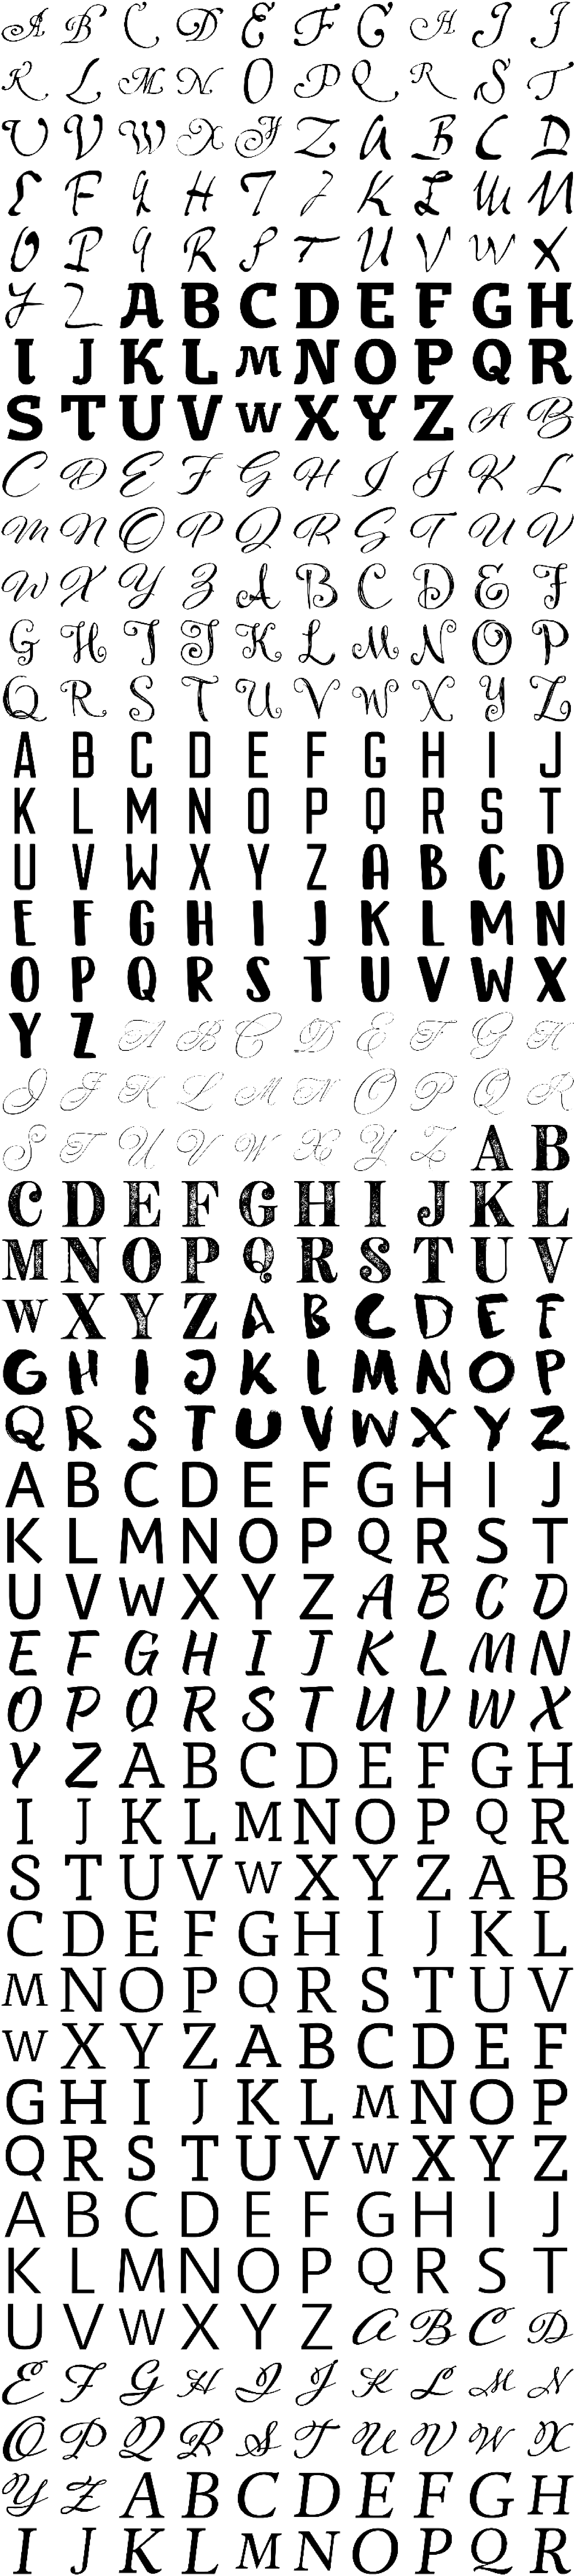

In [14]:
transform= Transform()
dataset = Myfont_dataset2(data[:10000], opts.correct_impression_word_list[:10000], ID, char_num = 26, transform=transform)
num = len(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=False, collate_fn = collate_fn)
tmp = dataloader.__iter__()
ground_truth = tmp.next()
ground_imgs = ground_truth['img_target']
ground_label = ground_truth['multi_label_target']
idx =  torch.tensor([idx for idx, label in enumerate(ground_label) if 'italic' in label])
ground_img = ground_imgs[idx]
print(len(ground_img))
row = len(ground_img)//10
col = 10
plt.figure(figsize=(col * 5 , row *5))
num = 0
while num < row * col:
    num += 1
    plt.subplot(row, col, num)
    plt.imshow(np.squeeze(ground_img[num-1]), cmap = "gray")
    plt.axis('off')

In [15]:
print(ground_label[::26][8])

['antique', 'rough', 'incunabula', 'ancient', 'rustic', 'party', 'bible']


# 2. 線形補間
## 2.1. Groundtruthとの類似

In [16]:
from models.DCmodel import ACGenerator
Imp2Font_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/Imp2Font/model_60'
G_model = CGenerator(weights, mask, z_dim=300, char_num=26, mode = 'C', emb = 'one-hot').to('cuda')
G_model = nn.DataParallel(G_model)
G_model.load_state_dict(torch.load(Cmodel_path)["G_model_state_dict"], strict=False)
G_model.eval()

DataParallel(
  (module): CGenerator(
    (layer1): Sequential(
      (0): Linear(in_features=326, out_features=1500, bias=True)
      (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer2): Sequential(
      (0): Linear(in_features=1574, out_features=1500, bias=True)
      (1): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer3): Sequential(
      (0): Linear(in_features=3000, out_features=32768, bias=True)
      (1): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer4): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

100%|██████████| 17202/17202 [00:04<00:00, 4161.49it/s]


427154
0
1
2
3
4
5
6
7
4
simple
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'heavy', 'legible', 'industrial', 'simple', 'text', 'modern', 'contemporary', 'robot', 'computer', 'gothic', 'logo', 'squarish', 'ligature', 'advertise', 'sans', 'serif', 'technology', 'bold', 'video', 'space', 'headline', 'alternate', 'grotesque', 'publish', 'branding', 'typeface', 'black', 'italic', 'digital', 'geometric', 'friendly', 'math', 'latin', 'sci', 'fi', 'business', 'square', 'poster', 'brand', 'commercial', 'fat', 'adaptable', 'game', 'techno', 'robotic', 'science', 'identity', 'cool', 'sans', 'video', 'game', 'mechanic', 'modular', 'technical', 'light', 'industry', 'title', 'neutral', 'round', 'magazine', 'branding', 'font', 'minimal', 'clean', 'mechanical', 'military', 'corporate', 'display', 'futuristic', 'small', 'caps'] 72


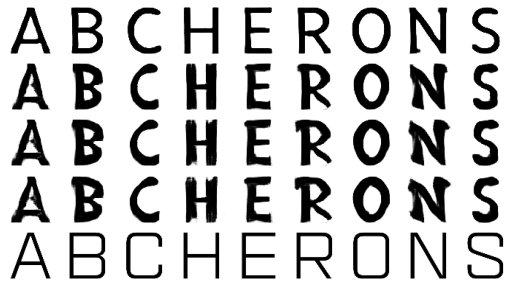

8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
16
serif
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'heavy', 'legible', 'industrial', 'simple', 'text', 'modern', 'contemporary', 'robot', 'computer', 'gothic', 'logo', 'squarish', 'ligature', 'advertise', 'sans', 'serif', 'technology', 'bold', 'video', 'space', 'headline', 'alternate', 'grotesque', 'publish', 'branding', 'typeface', 'black', 'italic', 'digital', 'geometric', 'friendly', 'math', 'latin', 'sci', 'fi', 'business', 'square', 'poster', 'brand', 'commercial', 'fat', 'adaptable', 'game', 'techno', 'robotic', 'science', 'identity', 'cool', 'sans', 'video', 'game', 'mechanic', 'modular', 'technical', 'light', 'industry', 'title', 'neutral', 'round', 'magazine'

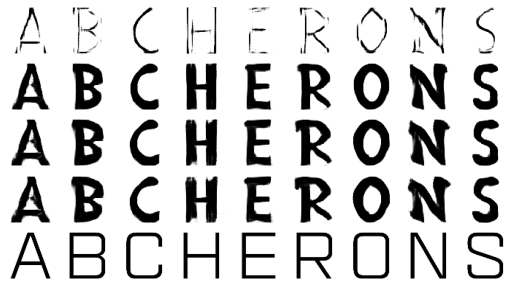

72
73
74
75
76
77
2
brush
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['fashion', 'hand', 'brush', 'graceful', 'casual', 'script', 'calligraphic', 'italic', 'handwrite', 'letter', 'calligraphy', 'wed', 'round', 'invitation', 'cursive', 'swash'] 16


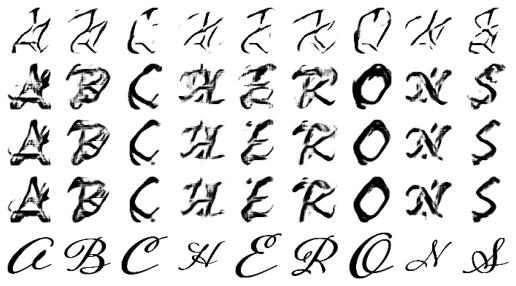

78
79
80
81
82
3
text
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['legible', 'rhythm', 'informal', 'text', 'contemporary', 'upright', 'italic', 'sans', 'serif', 'elegant', 'book', 'clean', 'sharp', 'small', 'caps', 'round', 'kid'] 17


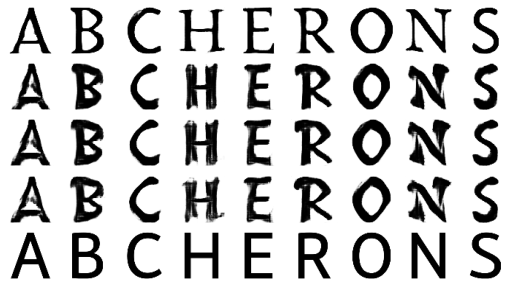

83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
0
decorative
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'some', 'bold', 'package', 'food', 'soft', 'ukrainian', 'slab', 'serif', 'round', 'fantasy', 'magazine', 'title', 'cyrillic', 'italic', 'child', 'logo', 'slab', 'friendly'] 19


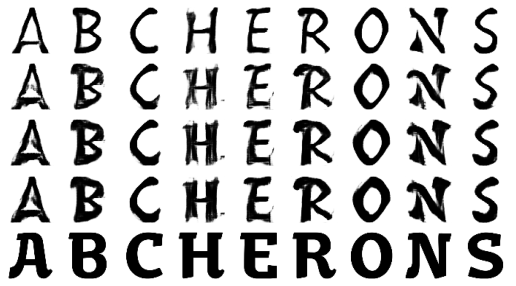

141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
1
hairline
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['heavy', 'hairline', 'family', 'text', 'modern', 'sharp', 'screen', 'logo', 'slab', 'superfamily', 'web', 'headline', 'calligraphic', 'italic', 'friendly', 'minimal', 'gill', 'legible', 'bold', 'poster', 'brand', 'serif', 'strong', 'ink', 'traps', 'clear', 'magazine', 'thin', 'clean', 'cursive', 'pack'] 31


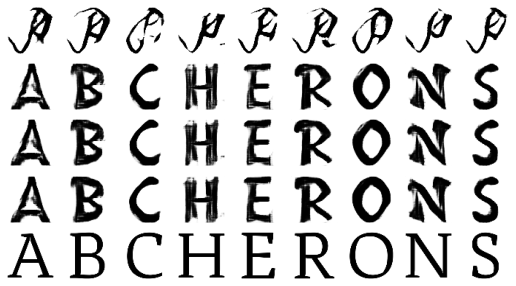

159
160
161
0
small
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['small', 'caps', 'old', 'style', 'serif', 'calligraphic', 'renaissance', 'roman', 'italic', 'calligraphy', 'italian'] 11


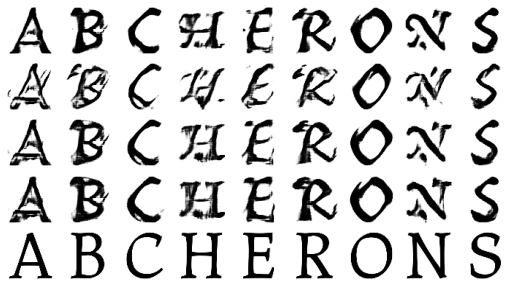

162
163
2
unique
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['ornamental', 'logo', 'unique', 'ornament', 'ampersand', 'italic', 'bold', 'cursive', 'swash'] 9


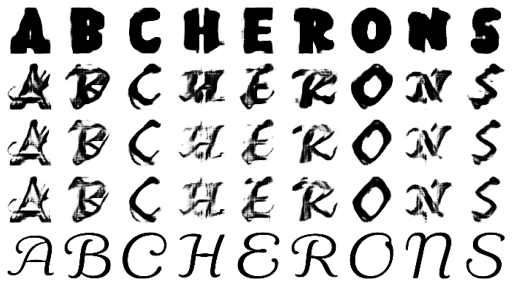

164
165
166
167
168
169
170
171
172
173
15
sans
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'heavy', 'legible', 'industrial', 'simple', 'text', 'modern', 'contemporary', 'robot', 'computer', 'gothic', 'logo', 'squarish', 'ligature', 'advertise', 'sans', 'serif', 'technology', 'bold', 'video', 'space', 'headline', 'alternate', 'grotesque', 'publish', 'branding', 'typeface', 'black', 'italic', 'digital', 'geometric', 'friendly', 'math', 'latin', 'sci', 'fi', 'business', 'square', 'poster', 'brand', 'commercial', 'fat', 'adaptable', 'game', 'techno', 'robotic', 'science', 'identity', 'cool', 'sans', 'video', 'game', 'mechanic', 'modular', 'technical', 'light', 'industry', 'title', 'neutral', 'round', 'magazine', 'branding', 'font', 'minimal', 'clean', 'mechanical', 'military', 'corporate', 'display', 'futuristic', 'small', 'caps'] 72


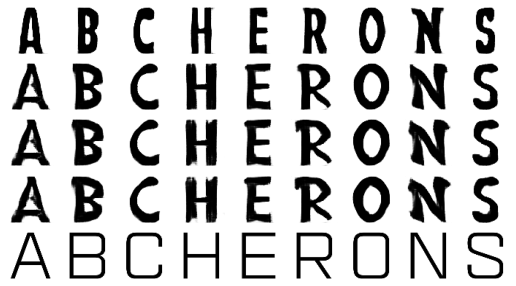

174
175
176
0
ornamental
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['ornamental', 'elegant', 'calligraphy', 'certificate', 'calligraphic', 'script', 'italic', 'handwrite', 'chancery', 'europe', 'wed', 'manual', 'greet', 'menu', 'invitation', 'cursive', 'loop'] 17


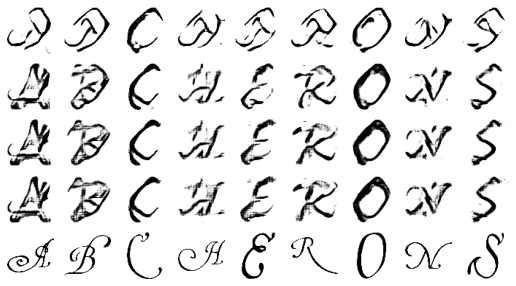

177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
8
book
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['beautiful', 'fashion', 'love', 'family', 'classic', 'spring', 'fancy', 'elegant', 'book', 'cover', 'flower', 'quaint', 'alternate', 'ornament', 'italic', 'sweet', 'stationery', 'christmas', 'coffee', 'feminine', 'serif', 'birthday', 'delicate', 'upright', 'flourish', 'formal', 'wed', 'roman', 'marriage', 'thin', 'invitation', 'swash', 'display'] 33


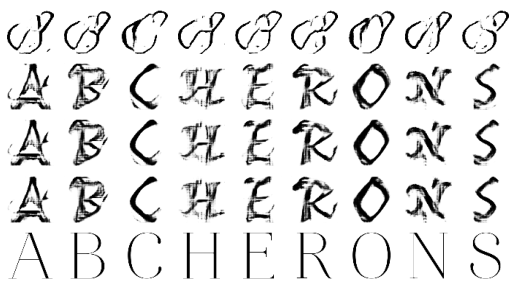

220
221
222
223
224
225
226
227
228
9
superfamily
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['heavy', 'hairline', 'family', 'text', 'modern', 'sharp', 'screen', 'logo', 'slab', 'superfamily', 'web', 'headline', 'calligraphic', 'italic', 'friendly', 'minimal', 'gill', 'legible', 'bold', 'poster', 'brand', 'serif', 'strong', 'ink', 'traps', 'clear', 'magazine', 'thin', 'clean', 'cursive', 'pack'] 31


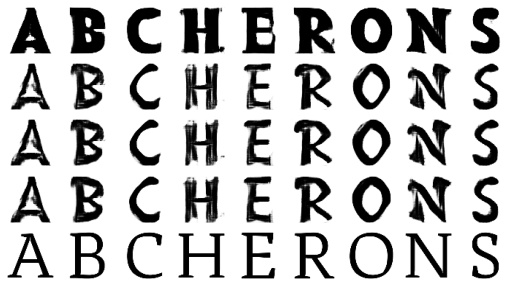

229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
9
hand
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'whimsical', 'fashion', 'distress', 'letterpress', 'classic', 'modern', 'contemporary', 'magazine', 'hand', 'drawn', 'texture', 'ink', 'ligature', 'advertise', 'casual', 'rough', 'title', 'headline', 'distinctive', 'alternate', 'handmade', 'condense', 'publish', 'write', 'pen', 'book', 'retro', 'italic', 'print', 'quirky', 'friendly', 'contrast', 'handwrite', 'vintage', 'draw', 'grunge', 'bold', 'food', 'poster', 'brand', 'hand', 'craft', 'letter', 'organic', 'unique', 'stamp', 'natural', 'package', 'serif', 'editorial', 'fun', 'swash', 'capital', 'sharp', 's', 'display'] 57


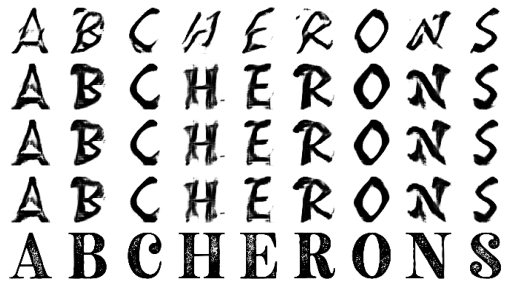

246
247
248
249
250
251
252
253
254
255
2
revival
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'certificate', 'revival', 'script', 'vintage', 'wed', 'calligraphic', 'handwrite', 'retro', 'french', 'italic', 'invitation', 'greet', 'cursive'] 14


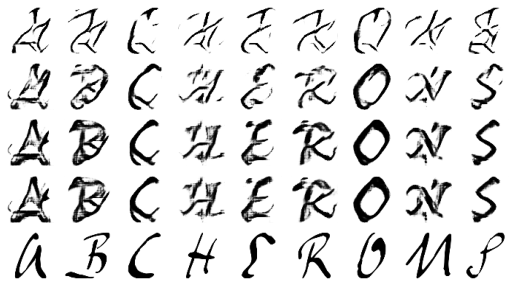

256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
3
text
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['legible', 'rhythm', 'informal', 'text', 'contemporary', 'upright', 'italic', 'sans', 'serif', 'elegant', 'book', 'clean', 'sharp', 'small', 'caps', 'round', 'kid'] 17


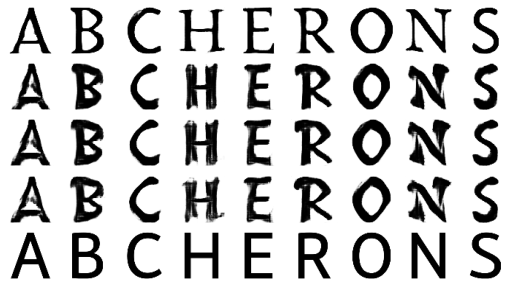

275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
2
informal
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['legible', 'rhythm', 'informal', 'text', 'contemporary', 'upright', 'italic', 'sans', 'serif', 'elegant', 'book', 'clean', 'sharp', 'small', 'caps', 'round', 'kid'] 17


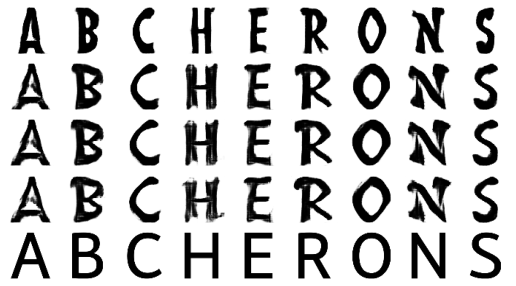

293
3
romantic
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'tattoo', 'swash', 'romantic', 'pretty', 'curly', 'script', 'fancy', 'calligraphic', 'elegant', 'brush', 'italic', 'handwrite', 'wed', 'cursive', 'hand', 'feminine', 'delicate'] 18


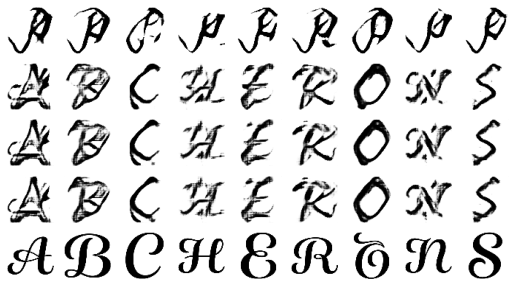

294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
18
headline
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'whimsical', 'fashion', 'distress', 'letterpress', 'classic', 'modern', 'contemporary', 'magazine', 'hand', 'drawn', 'texture', 'ink', 'ligature', 'advertise', 'casual', 'rough', 'title', 'headline', 'distinctive', 'alternate', 'handmade', 'condense', 'publish', 'write', 'pen', 'book', 'retro', 'italic', 'print', 'quirky', 'friendly', 'contrast', 'handwrite', 'vintage', 'draw', 'grunge', 'bold', 'food', 'poster', 'brand', 'hand', 'craft', 'letter', 'organic', 'unique', 'stamp', 'natural', 'package', 'serif', 'editorial', 'fun', 'swash', 'capital', 'sharp', 's', 'display'] 57


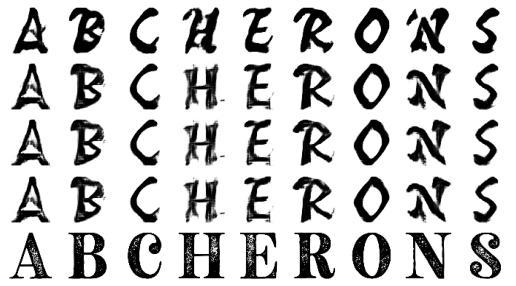

326
327
328
329
330
331
332
333
334
335
0
legible
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['legible', 'rhythm', 'informal', 'text', 'contemporary', 'upright', 'italic', 'sans', 'serif', 'elegant', 'book', 'clean', 'sharp', 'small', 'caps', 'round', 'kid'] 17


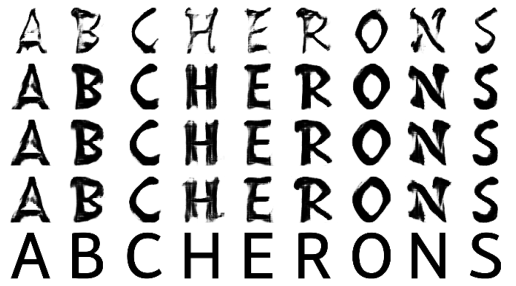

336
337
338
6
oblique
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['heavy', 'all', 'caps', 'ligature', 'editorial', 'simple', 'oblique', 'features', 'logo', 'serif', 'web', 'headline', 'alternate', 'condense', 'black', 'italic', 'bold', 'poster', 'slant', 'regular', 'sans', 'package', 'cap', 'round', 'magazine', 'clean', 'capital', 'sharp', 's', 'display'] 30


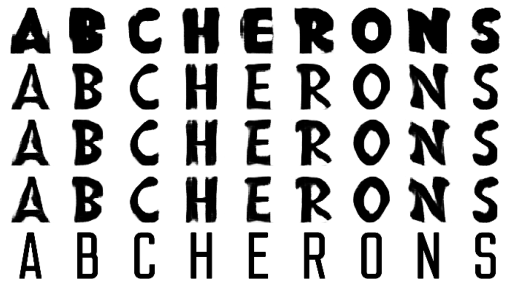

339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
1
art
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['cute', 'art', 'handcraft', 'contemporary', 'elegant', 'connect', 'logo', 'rough', 'curly', 'script', 'informal', 'handmade', 'magazine', 'label', 'write', 'book', 'italic', 'penmanship', 'lovely', 'sweet', 'friendly', 'handwrite', 'poster', 'multilingual', 'slant', 'hand', 'artwork', 'calligraphy', 'card', 'romantic', 'stylish', 'greet', 'fun', 'greeting', 'card'] 35


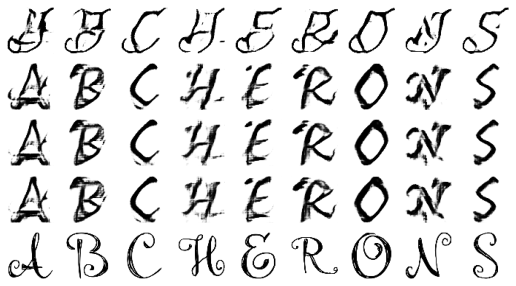

354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
4
italic
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['antique', 'decorative', 'script', 'ancient', 'italic', 'church', 'fashionable', 'century', 'calligraphic', 'scribal', 'renaissance', 'swash', 'handwrite', 'ink', 'mysterious', 'calligraphy'] 16


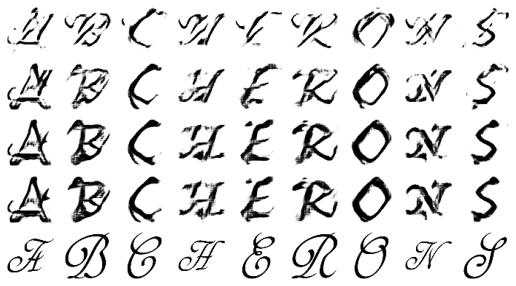

372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
3
energy
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['ligature', 'organic', 'rhythm', 'energy', 'flow', 'fluid', 'stroke', 'script', 'pen', 'craft', 'swash', 'brush', 'italic', 'calligraphy', 'delicate'] 15


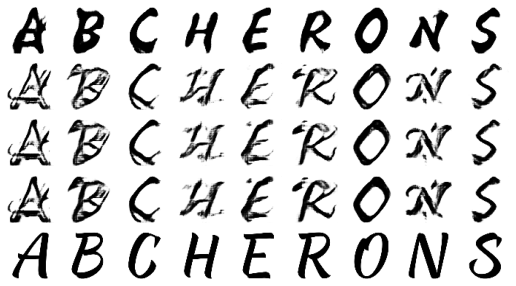

434
435
436
437
438
439
440
441
442
443
0
decorative
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'whimsical', 'fashion', 'distress', 'letterpress', 'classic', 'modern', 'contemporary', 'magazine', 'hand', 'drawn', 'texture', 'ink', 'ligature', 'advertise', 'casual', 'rough', 'title', 'headline', 'distinctive', 'alternate', 'handmade', 'condense', 'publish', 'write', 'pen', 'book', 'retro', 'italic', 'print', 'quirky', 'friendly', 'contrast', 'handwrite', 'vintage', 'draw', 'grunge', 'bold', 'food', 'poster', 'brand', 'hand', 'craft', 'letter', 'organic', 'unique', 'stamp', 'natural', 'package', 'serif', 'editorial', 'fun', 'swash', 'capital', 'sharp', 's', 'display'] 57


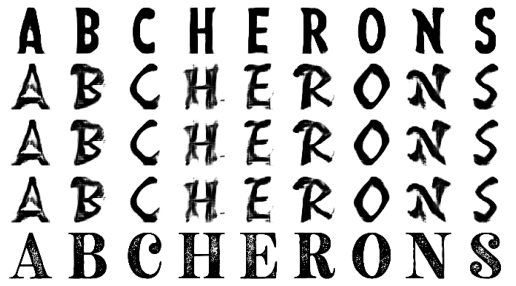

444
445
446
4
pretty
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'tattoo', 'swash', 'romantic', 'pretty', 'curly', 'script', 'fancy', 'calligraphic', 'elegant', 'brush', 'italic', 'handwrite', 'wed', 'cursive', 'hand', 'feminine', 'delicate'] 18


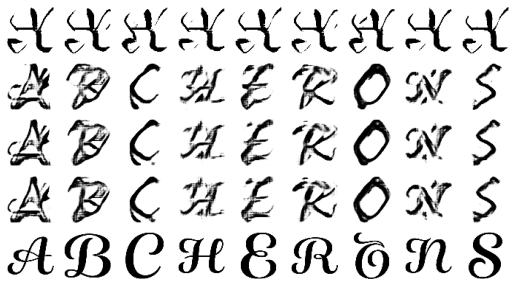

447
448
449
450
7
handwrite
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['fashion', 'logo', 'random', 'fancy', 'elegant', 'hand', 'brush', 'handwrite', 'ligature', 'calligraphic', 'casual', 'unusual', 'script', 'ornament', 'symbol', 'italic', 'swash', 'feminine', 'letter', 'unique', 'icon', 'wed', 'artistic', 'invitation', 'cursive', 'swash'] 26


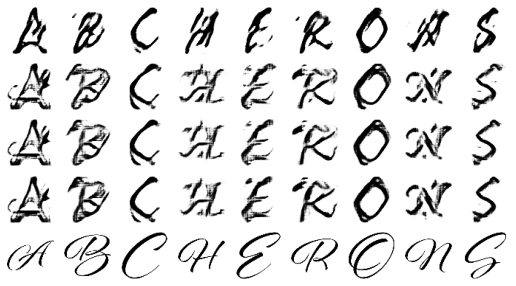

451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
3
graceful
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['fashion', 'hand', 'brush', 'graceful', 'casual', 'script', 'calligraphic', 'italic', 'handwrite', 'letter', 'calligraphy', 'wed', 'round', 'invitation', 'cursive', 'swash'] 16


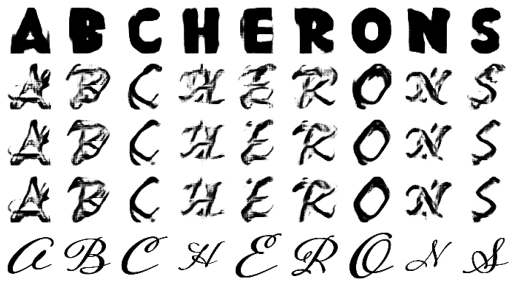

468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
0
decorative
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'vintage', 'woodcut', 'usa', 'oblique', 'victorian', 'rustic', 'elegant', 'american', 'italic', 'wild', 'west', 'grand', 'display', 'caps'] 15


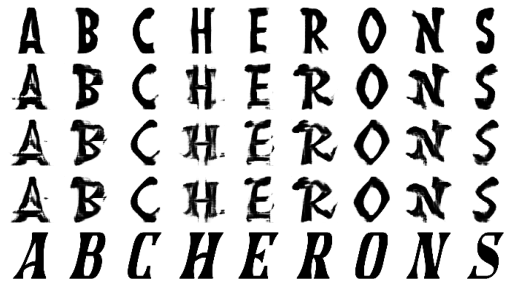

542
543
2
fashion
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'whimsical', 'fashion', 'distress', 'letterpress', 'classic', 'modern', 'contemporary', 'magazine', 'hand', 'drawn', 'texture', 'ink', 'ligature', 'advertise', 'casual', 'rough', 'title', 'headline', 'distinctive', 'alternate', 'handmade', 'condense', 'publish', 'write', 'pen', 'book', 'retro', 'italic', 'print', 'quirky', 'friendly', 'contrast', 'handwrite', 'vintage', 'draw', 'grunge', 'bold', 'food', 'poster', 'brand', 'hand', 'craft', 'letter', 'organic', 'unique', 'stamp', 'natural', 'package', 'serif', 'editorial', 'fun', 'swash', 'capital', 'sharp', 's', 'display'] 57


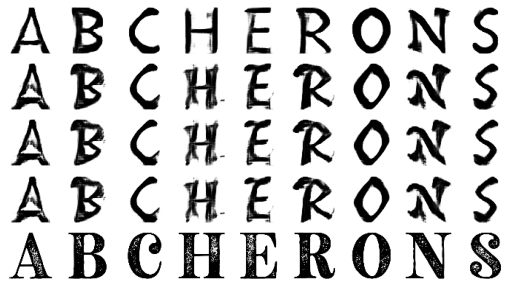

544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
15
casual
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'whimsical', 'fashion', 'distress', 'letterpress', 'classic', 'modern', 'contemporary', 'magazine', 'hand', 'drawn', 'texture', 'ink', 'ligature', 'advertise', 'casual', 'rough', 'title', 'headline', 'distinctive', 'alternate', 'handmade', 'condense', 'publish', 'write', 'pen', 'book', 'retro', 'italic', 'print', 'quirky', 'friendly', 'contrast', 'handwrite', 'vintage', 'draw', 'grunge', 'bold', 'food', 'poster', 'brand', 'hand', 'craft', 'letter', 'organic', 'unique', 'stamp', 'natural', 'package', 'serif', 'editorial', 'fun', 'swash', 'capital', 'sharp', 's', 'display'] 57


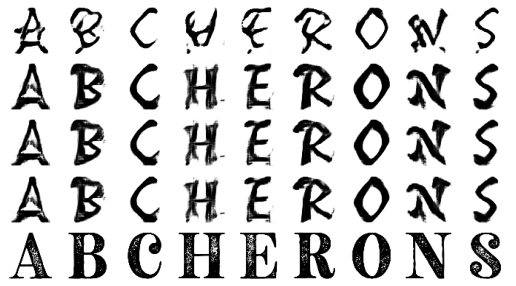

595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
23
grotesque
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'heavy', 'legible', 'industrial', 'simple', 'text', 'modern', 'contemporary', 'robot', 'computer', 'gothic', 'logo', 'squarish', 'ligature', 'advertise', 'sans', 'serif', 'technology', 'bold', 'video', 'space', 'headline', 'alternate', 'grotesque', 'publish', 'branding', 'typeface', 'black', 'italic', 'digital', 'geometric', 'friendly', 'math', 'latin', 'sci', 'fi', 'business', 'square', 'poster', 'brand', 'commercial', 'fat', 'adaptable', 'game', 'techno', 'robotic', 'science', 'identity', 'cool', 'sans', 'video', 'game', 'mechanic', 'modular', 'technical', 'light', 'industry', 'title', 'neutral

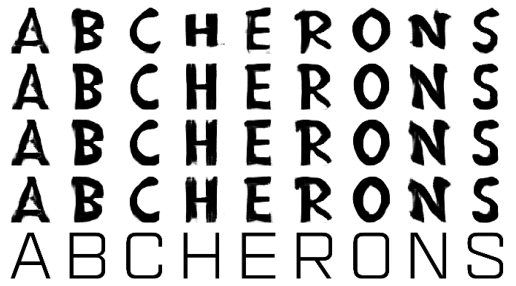

647
648
649
1
vintage
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'vintage', 'woodcut', 'usa', 'oblique', 'victorian', 'rustic', 'elegant', 'american', 'italic', 'wild', 'west', 'grand', 'display', 'caps'] 15


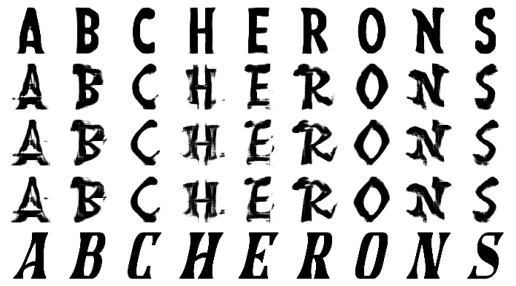

650
651
652
653
654
655
656
657
658
659
660
661
662
663
7
advertise
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['cute', 'ad', 'product', 'packaging', 'contemporary', 'brush', 'ink', 'advertise', 'cover', 'open', 'handmade', 'book', 'italic', 'lovely', 'christmas', 'happy', 'website', 'product', 'poster', 'multilingual', 'fat', 'hand', 'outline', 'package', 'xmas', 'neat', 'fun', 'round'] 28


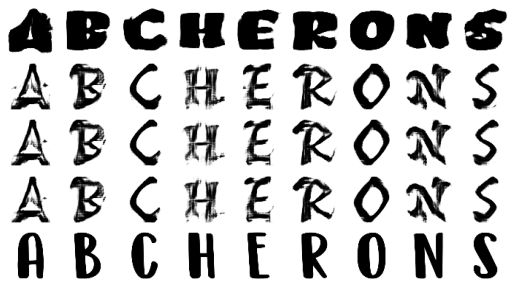

664
665
666
667
668
669
670
671
672
673
3
usa
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'vintage', 'woodcut', 'usa', 'oblique', 'victorian', 'rustic', 'elegant', 'american', 'italic', 'wild', 'west', 'grand', 'display', 'caps'] 15


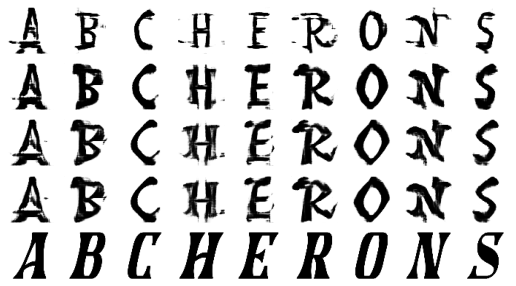

674
675
676
4
calligraphic
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['ornamental', 'elegant', 'calligraphy', 'certificate', 'calligraphic', 'script', 'italic', 'handwrite', 'chancery', 'europe', 'wed', 'manual', 'greet', 'menu', 'invitation', 'cursive', 'loop'] 17


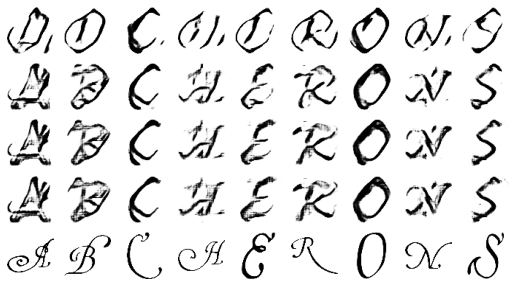

677
678
5
simple
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['heavy', 'all', 'caps', 'ligature', 'editorial', 'simple', 'oblique', 'features', 'logo', 'serif', 'web', 'headline', 'alternate', 'condense', 'black', 'italic', 'bold', 'poster', 'slant', 'regular', 'sans', 'package', 'cap', 'round', 'magazine', 'clean', 'capital', 'sharp', 's', 'display'] 30


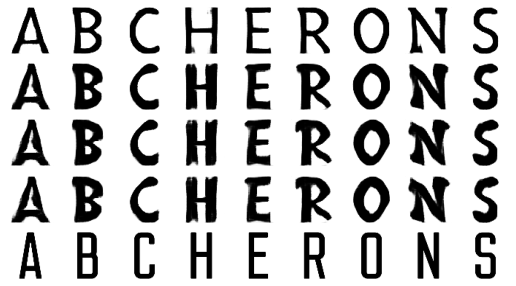

679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
8
logo
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['art', 'album', 'cover', 'product', 'packaging', 'contemporary', 'ink', 'messy', 'logo', 'book', 'cover', 'free', 'flowing', 'winter', 'curly', 'script', 'informal', 'ligature', 'handmade', 'magazine', 'label', 'write', 'book', 'italic', 'handcraft', 'christmas', 'handwrite', 'poster', 'multilingual', 'slant', 'hand', 'artwork', 'card', 'flow', 'greet', 'splatter', 'chinese', 'ink', 'quick', 'greeting', 'card', 'brush'] 42


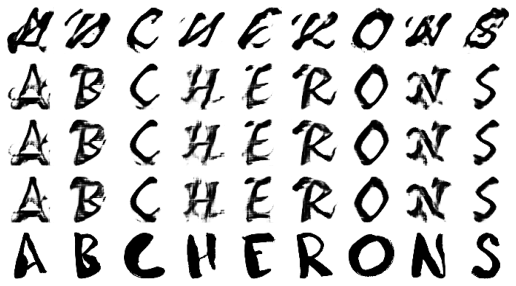

698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
0
fashion
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['fashion', 'hand', 'brush', 'graceful', 'casual', 'script', 'calligraphic', 'italic', 'handwrite', 'letter', 'calligraphy', 'wed', 'round', 'invitation', 'cursive', 'swash'] 16


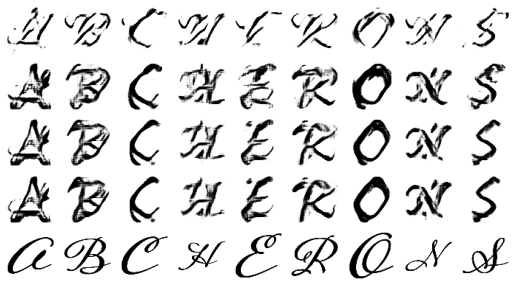

737
738
739
740
741
6
slab
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['heavy', 'hairline', 'text', 'modern', 'screen', 'logo', 'slab', 'superfamily', 'web', 'ink', 'traps', 'italic', 'friendly', 'gill', 'legible', 'bold', 'brand', 'clear', 'magazine', 'thin', 'clean', 'corporate', 'pack'] 23


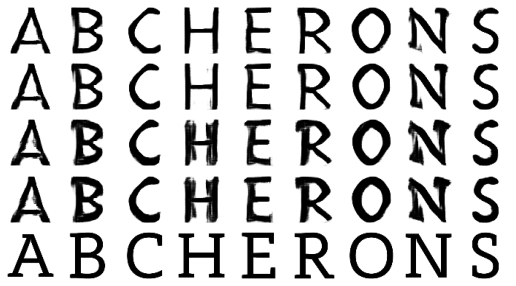

742
743
744
745
5
logo
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['heavy', 'hairline', 'text', 'modern', 'screen', 'logo', 'slab', 'superfamily', 'web', 'ink', 'traps', 'italic', 'friendly', 'gill', 'legible', 'bold', 'brand', 'clear', 'magazine', 'thin', 'clean', 'corporate', 'pack'] 23


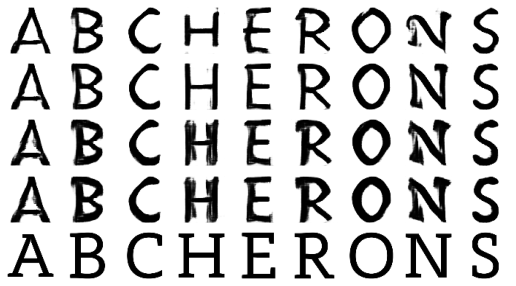

746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
6
wizard
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['shop', 'fashion', 'family', 'awesome', 'fancy', 'stencil', 'wizard', 'book', 'italic', 'print', 'typo', 'commercial', 'serif', 'ad', 'kid', 'school', 'mono', 'sale', 'monoline', 'magazine', 'display', 'pack'] 22


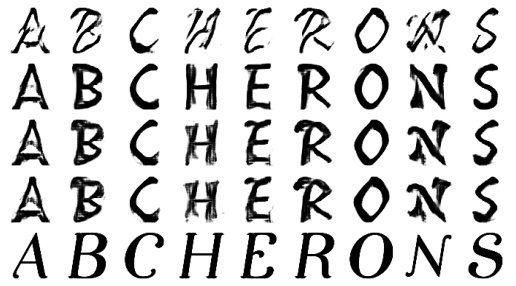

777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
0
decorative
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'whimsical', 'fashion', 'distress', 'letterpress', 'classic', 'modern', 'contemporary', 'magazine', 'hand', 'drawn', 'texture', 'ink', 'ligature', 'advertise', 'casual', 'rough', 'title', 'headline', 'distinctive', 'alternate', 'handmade', 'condense', 'publish', 'write', 'pen', 'book', 'retro', 'italic', 'print', 'quirky', 'friendly', 'contrast', 'handwrite', 'vintage', 'draw', 'grunge', 'bold', 'food', 'poster', 'brand', 'hand', 'craft', 'letter', 'organic', 'unique', 'stamp', 'natural', 'package', 'serif', 'editorial', 'fun', 'swash', 'capital', 'sharp', 's', 'display'] 57


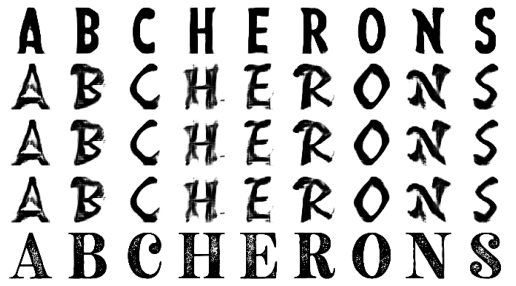

814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
1
organic
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['ligature', 'organic', 'rhythm', 'energy', 'flow', 'fluid', 'stroke', 'script', 'pen', 'craft', 'swash', 'brush', 'italic', 'calligraphy', 'delicate'] 15


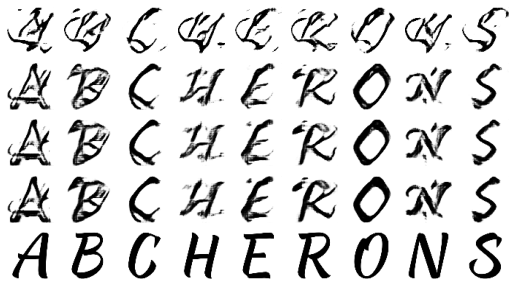

829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
1
tattoo
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'tattoo', 'swash', 'romantic', 'pretty', 'curly', 'script', 'fancy', 'calligraphic', 'elegant', 'brush', 'italic', 'handwrite', 'wed', 'cursive', 'hand', 'feminine', 'delicate'] 18


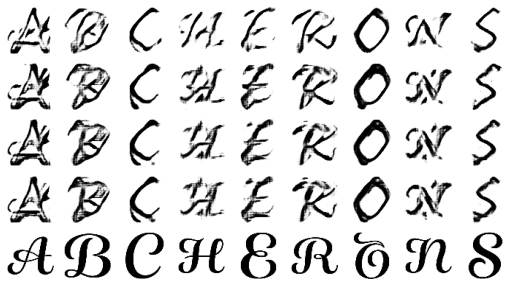

873
874
875
876
877
6
slab
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['heavy', 'hairline', 'text', 'modern', 'screen', 'logo', 'slab', 'superfamily', 'web', 'ink', 'traps', 'italic', 'friendly', 'gill', 'legible', 'bold', 'brand', 'clear', 'magazine', 'thin', 'clean', 'corporate', 'pack'] 23


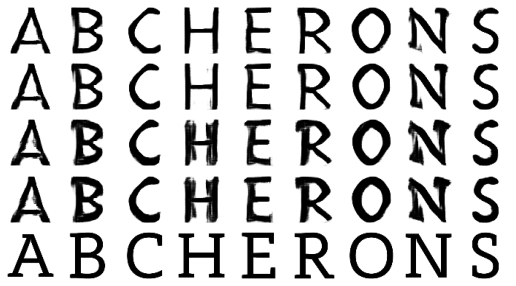

878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
4
flow
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['ligature', 'organic', 'rhythm', 'energy', 'flow', 'fluid', 'stroke', 'script', 'pen', 'craft', 'swash', 'brush', 'italic', 'calligraphy', 'delicate'] 15


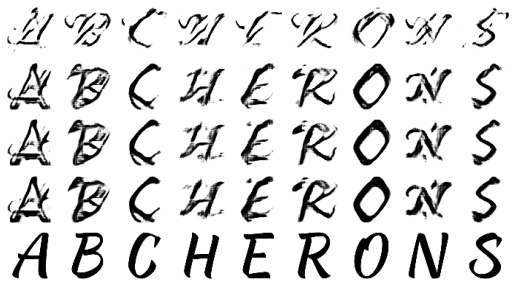

897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
1
logo
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['ornamental', 'logo', 'unique', 'ornament', 'ampersand', 'italic', 'bold', 'cursive', 'swash'] 9


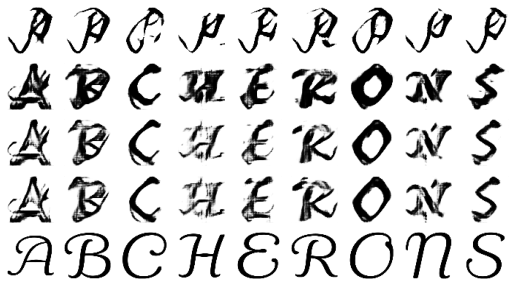

912
1
decorative
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['antique', 'decorative', 'script', 'ancient', 'italic', 'church', 'fashionable', 'century', 'calligraphic', 'scribal', 'renaissance', 'swash', 'handwrite', 'ink', 'mysterious', 'calligraphy'] 16


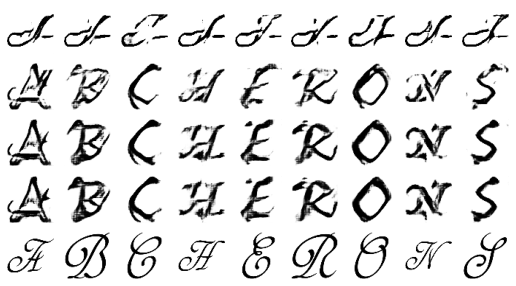

913
0
decorative
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['decorative', 'some', 'bold', 'package', 'food', 'soft', 'ukrainian', 'slab', 'serif', 'round', 'fantasy', 'magazine', 'title', 'cyrillic', 'italic', 'child', 'logo', 'slab', 'friendly'] 19


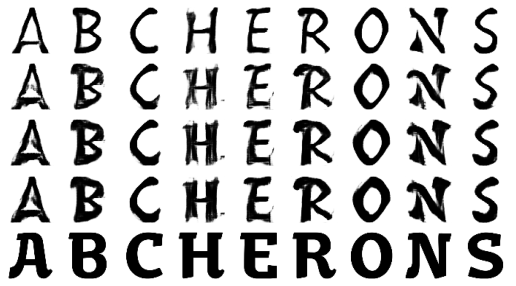

914
915
916
917
918
2
unique
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['ornamental', 'logo', 'unique', 'ornament', 'ampersand', 'italic', 'bold', 'cursive', 'swash'] 9


KeyboardInterrupt: 

In [17]:
transform= Transform()
dataset = Myfont_dataset2(data, opts.correct_impression_word_list, ID, char_num = 26, transform=transform)
num = len(dataset)
print(num)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(data), shuffle=False, collate_fn = collate_fn)
tmp = dataloader.__iter__()
ground_truth = tmp.next()
for i in range(100000):
    print(i)
    ground_img = ground_truth['img_target']
    ground_label = ground_truth['multi_label_target']
    ground_label_oh = ground_truth['multi_embed_label_target']
    random.seed(i) 
    idx1 = random.choice(list(range(len(ground_img))))
    if 'italic' not in ground_label[idx1]:
        continue
    condition = Multilabel_OneHot([ground_label_oh[idx1]],len(ID), normalize = True)
    devide_num = -(-len(ground_label_oh[idx1]))//3
    cond = []
    for i in range(4):
        if i==0:
            one = random.choice(list(range(devide_num)))
            print(one)
            print(ground_label[idx1][one])
            cond.append([list(reversed(ground_label_oh[idx1]))[:devide_num][one]])
        else:
            cond.append(list(reversed(ground_label_oh[idx1]))[:i*devide_num])
    cond = torch.cat([Multilabel_OneHot([c],len(ID), normalize = True) for c in cond])
    print(cond)
    aaa = torch.tensor([0, 1, 2, 7, 4, 17, 14, 13, 18])
    char_num = len(aaa)
    gen_num = 4
    ground_img= ((ground_img[idx1-(idx1%26) :idx1-(idx1%26)+26][aaa]/2)+0.5)
    # word1 = [[ID[token] for token in word_list]
    # for idx, i in enumerate(range(imp_num)):
    #     c += word1[:,i,:]
    #     condition.append(c/(idx+1))
    char_class = torch.eye(26)[aaa].repeat(len(cond),1).to(device)
    condition = tile(cond, 0 , char_num).to(device)
    torch.manual_seed(12
                     )
    noise = torch.normal(mean = 0.5, std = 0.2, size = (1, 300))
    noise = noise.repeat(char_num *  len(cond), 1).to(device)
    with torch.no_grad():
        samples = G_model(noise, condition, char_class)
        samples = samples.data.cpu()
        samples = (samples/2)+0.5
    samples = np.concatenate([samples, ground_img], axis = 0)
    row = len(cond) + 1
    col = char_num
    plt.figure(figsize=(col , row))
    num = 0
    print(ground_label[idx1], len(ground_label[idx1]))
    while num < row * col:
        num += 1
        plt.subplot(row, col, num)
        plt.imshow(np.squeeze(samples[num-1]), cmap = "gray")
        plt.axis('off')
    plt.show()

In [ ]:
word1 = ['italic']
word1 = [[ID[token] for token in word1]]
word1 = Multilabel_OneHot(word1, len(ID))
word1 = torch.tensor(word1)
word2 = ['serif'] 
word2 = [[ID[token] for token in word2]]
word2 = Multilabel_OneHot(word2, len(ID))
word2 = torch.tensor(word2)
aaa = torch.tensor([0, 1, 2, 7, 4, 17, 14, 13, 18])
char_num = len(aaa)
char_class = torch.eye(26)[aaa].repeat(6, 1).to(device)
alpha_list=np.linspace(0,1,6)
condition = torch.cat([(1-alpha) * word1 + alpha * word2 for alpha in alpha_list])
condition = tile(condition, 0 , char_num).to(device)
noise = torch.normal(mean = 0.5, std = 0.2, size = (1, 300))
noise = noise.repeat(char_num * len(alpha_list), 1).to(device)
with torch.no_grad():
    samples = G_model(noise, condition, char_class)
    samples = samples.data.cpu()
    samples = (samples/2)+0.5
row =  len(alpha_list)
col = char_num
plt.figure(figsize=(col , row))
num = 0
while num < row * col:
    num += 1
    plt.subplot(row, col, num)
    plt.imshow(np.squeeze(samples[num-1]), cmap = "gray")
    plt.axis('off')
    

## 2,2 ノイズの変動

In [18]:
word =['serif']
aaa = torch.tensor([0, 1, 2, 7, 4, 17, 14, 13, 18])
char_num = len(aaa)
label = [[ID[token] for token in word]]
condition = Multilabel_OneHot(label, len(ID), normalize = True)
noise1 =  torch.normal(mean = 0.5, std = 0.2, size = (1, 300))
noise2 =  torch.normal(mean = 0.5, std = 0.2, size = (1, 300))
char_class = torch.eye(26)[aaa].repeat(6, 1).to(device)
alpha_list=np.linspace(0,1,6)
noise = torch.cat([(1-alpha) * noise1 + alpha * noise2 for alpha in alpha_list])
noise = tile(noise, 0 , char_num).to(device)
condition= torch.tensor(condition).repeat(char_num * len(alpha_list), 1).to(device)
print(noise.size(),condition.size(), char_class.size())
with torch.no_grad():
    samples = G_model(noise, condition, char_class)
    samples = samples.data.cpu()
    samples = (samples/2)+0.5

torch.Size([54, 300]) torch.Size([54, 1574]) torch.Size([54, 26])


<ipython-input-18-a7c9975d3832>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  condition= torch.tensor(condition).repeat(char_num * len(alpha_list), 1).to(device)


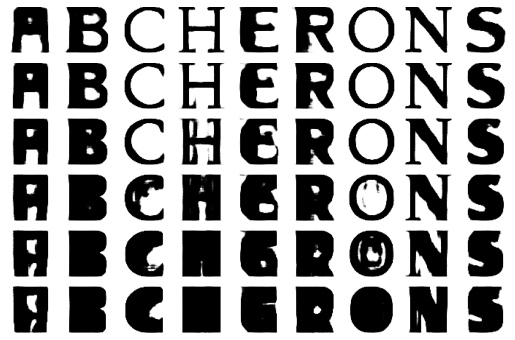

In [19]:
import matplotlib.pyplot as plt
row =  len(alpha_list)
col = char_num
plt.figure(figsize=(col , row))
num = 0
while num < row * col:
    num += 1
    plt.subplot(row, col, num)
    plt.imshow(np.squeeze(samples[num-1]), cmap = "gray")
    plt.axis('off')

# 3.様々印象からAを生成

In [24]:
imp = random.sample(list(ID.keys()), len(list(ID.keys())))[:100]
condition = torch.stack([torch.tensor(Embedding_model[token]) for token in imp])
noise =  torch.normal(mean = 0.5, std = 0.2, size = (100, 300))
char_class = torch.eye(26)[0].repeat(100, 1).to(device)
print(noise.size(), condition.size(), char_class.size())
with torch.no_grad():
    samples = G_model(noise, condition, char_class, w2v = False)
    samples = samples.data.cpu()
    samples = (samples/2)+0.5

torch.Size([100, 300]) torch.Size([100, 1, 300]) torch.Size([100, 26])


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 60, in _worker
    output = module(*input, **kwargs)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/matsuda/デスクトップ/Imp2Font/models/DCmodel.py", line 242, in forward
    y_2 = self.layer2(attr)  # (300,1,1)⇒(1500,1,1)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/container.py", line 100, in forward
    input = module(input)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/linear.py", line 87, in forward
    return F.linear(input, self.weight, self.bias)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py", line 1612, in linear
    output = input.matmul(weight.t())
RuntimeError: size mismatch, m1: [50 x 300], m2: [1574 x 1500] at /opt/conda/conda-bld/pytorch_1587428207430/work/aten/src/THC/generic/THCTensorMathBlas.cu:283


In [ ]:
import matplotlib.pyplot as plt
row =  10
col = 10
plt.figure(figsize=(col * 10 , row * 10))
plt.subplots_adjust(wspace=1.0, hspace =0.6)
num = 0
while num < row * col:
    num += 1
    plt.subplot(row, col, num)
    plt.title('{}'.format(imp[num-1]), fontsize=80)
    plt.imshow(np.squeeze(samples[num-1]), cmap = "gray")
    plt.axis('off')

# 4.特定の印象語を生成

In [28]:
condition = torch.cat([torch.tensor(Embedding_model['shading']).unsqueeze(0), torch.zeros(1573, 300)], axis = 0)
condition = condition.unsqueeze(0).repeat(100,1,1)
noise =  torch.normal(mean = 0.5, std = 0.2, size = (100, 300))
char_class = torch.eye(26)[0].repeat(100, 1).to(device)
print(noise.size(), condition.size(), char_class.size())
with torch.no_grad():
    samples = G_model(noise, condition, char_class, w2v = False)
    samples = samples.data.cpu()
    samples = (samples/2)+0.5

torch.Size([100, 300]) torch.Size([100, 1574, 300]) torch.Size([100, 26])


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 60, in _worker
    output = module(*input, **kwargs)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/matsuda/デスクトップ/Imp2Font/models/DCmodel.py", line 242, in forward
    y_2 = self.layer2(attr)  # (300,1,1)⇒(1500,1,1)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/container.py", line 100, in forward
    input = module(input)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/linear.py", line 87, in forward
    return F.linear(input, self.weight, self.bias)
  File "/home/matsuda/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py", line 1612, in linear
    output = input.matmul(weight.t())
RuntimeError: size mismatch, m1: [78700 x 300], m2: [1574 x 1500] at /opt/conda/conda-bld/pytorch_1587428207430/work/aten/src/THC/generic/THCTensorMathBlas.cu:283


In [ ]:
import matplotlib.pyplot as plt
row =  10
col = 10
plt.figure(figsize=(col * 10 , row * 10))
num = 0
while num < row * col:
    num += 1
    plt.subplot(row, col, num)
    plt.imshow(np.squeeze(samples[num-1]), cmap = "gray")
    plt.axis('off')

# フォント検索

In [ ]:
transform= Transform()
dataset = Myfont_dataset2(data, opts.correct_impression_word_list, ID, char_num = 1, transform=transform)
num = len(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(data), shuffle=False, collate_fn = collate_fn)
tmp = dataloader.__iter__()
ground_truth = tmp.next()
ground_img = ground_truth['img_target']
ground_label = ground_truth['multi_label_target']
ground_label_oh = ground_truth['multi_embed_label_target']
index = torch.tensor([idx for idx, label in enumerate(ground_label) if 'big' in label])
images = ground_img[index]
print(images.shape)
row = len(images)//10
col = 10
plt.figure(figsize=(col  , row ))
num = 0
while num < row * col:
    num += 1
    plt.subplot(row, col, num)
    plt.imshow(images[num-1].reshape(64, 64), cmap = "gray")
    plt.axis('off')
    

# 5.FIDの計算

In [ ]:
import numpy as np
import torch
import tensorflow as tf
from models.DCmodel import ACGenerator, CGenerator
from options import get_parser
import word2vec
from dataset import *
import random
import tqdm
import pprint
import torch.optim as optim
import numpy as np
from  mylib import *
from torchvision import models
from torch.autograd import Variable
import torch.nn as nn
from stealthflow.fid import FIDNumpy, FIDTF
device = 'cuda'

In [ ]:
Cmodel_path = './result/CGAN/checkpoint_cGAN/model_100'
ACmodel_path = './result/ACGAN/checkpoint_cpGAN/model_60'
CPmodel_path = './result/CPGAN/checkpoint_cpGAN/model_35'
parser = get_parser()
opts = parser.parse_args(args=[])
data = np.array([np.load(d) for d in opts.data])
Embedding_model = word2vec.word2vec()
weights = Embedding_model.vectors
ID = {}
c = 1
mask = []
for idx, key in enumerate(Embedding_model.vocab.keys()):
    if key in opts.w2v_vocab.keys():
        ID[key] = c
        c += 1
        mask.append(idx)
    else:
        continue

In [ ]:
import torch
SEED = 1111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
# CG_model = CGenerator(weights, mask, z_dim=300, char_num=26).to('cuda')
# CG_model = nn.DataParallel(CG_model)
# CG_model.load_state_dict(torch.load(Cmodel_path)["G_model_state_dict"], strict=False)
# CG_model.eval()
# ACG_model = ACGenerator(weights, mask, z_dim=300, char_num=26, mode='AC').to('cuda')
# ACG_model = nn.DataParallel(ACG_model)
# ACG_model.load_state_dict(torch.load(ACmodel_path)["G_model_state_dict"], strict=False)
# ACG_model.eval()
CPG_model = ACGenerator(weights, mask, z_dim=300, char_num=26, mode='CP').to('cuda')
CPG_model = nn.DataParallel(CPG_model)
CPG_model.load_state_dict(torch.load(CPmodel_path)["G_model_state_dict"], strict=False)
CPG_model.eval()

In [ ]:
transform= Transform()
dataset = Myfont_dataset2(data, opts.correct_impression_word_list, ID, char_num = 1, transform=transform)
num = len(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=num, shuffle=True, collate_fn = collate_fn)
tmp = dataloader.__iter__()
tmp1 = tmp.next()
labels = tmp1['multi_embed_label_target']
condition = Multilabel_OneHot(labels, len(ID), normalize = True)
noise =  torch.normal(mean = 0.5, std = 0.2, size = (num, 300))
char_class = torch.eye(26)[0].repeat(num, 1)
print(noise.size(), char_class.size(), condition.size())
fake_img_C = []
fake_img_AC = []
fake_img_CP = []
with torch.no_grad():
    for i in range(int(num/200)+1):
        samples= CG_model(noise[200*i:200*(i+1)], condition[200*i:200*(i+1)], char_class[200*i:200*(i+1)])
        samples = samples.data.cpu()
        samples = (samples/2)+0.5
        fake_img_C.append(samples)
with torch.no_grad():
    for i in range(int(num/200)+1):
        samples= ACG_model(noise[200*i:200*(i+1)], condition[200*i:200*(i+1)], char_class[200*i:200*(i+1)])
        samples = samples.data.cpu()
        samples = (samples/2)+0.5
        fake_img_AC.append(samples)
with torch.no_grad():
    for i in range(int(num/200)+1):
        samples= CPG_model(noise[200*i:200*(i+1)], condition[200*i:200*(i+1)], char_class[200*i:200*(i+1)])
        samples = samples.data.cpu()
        samples = (samples/2)+0.5
        fake_img_CP.append(samples)

In [ ]:
CG_model , ACG_model, CPG_model= None,None, None
fake_img_C = np.concatenate(fake_img_C)
fake_img_AC = np.concatenate(fake_img_AC)
fake_img_CP = np.concatenate(fake_img_CP)

In [ ]:
from dataset import *
real_imgs = tmp1['img_target'].detach().numpy()
real_imgs= (real_imgs/2)+0.5
real_imgs = real_imgs.transpose(0,2,3,1)
fake_imgs_C = fake_img_C.transpose(0,2,3,1)
fake_imgs_AC = fake_img_AC.transpose(0,2,3,1)
fake_imgs_CP = fake_img_CP.transpose(0,2,3,1)

In [ ]:
fid_score = FIDNumpy(batch_size=50, scaling=True)(real_imgs, fake_imgs)
print("FID numpy: ", fid_score)

# images1 = tf.constant(images1, dtype=tf.float32)
# images2 = tf.constant(images2, dtype=tf.float32)

# images1 = tf.convert_to_tensor(images1, dtype=tf.float32)
# images2 = tf.convert_to_tensor(images2, dtype=tf.float32)

# fid_score = FIDTF(batch_size=50, scaling=True)(images1, images2)
# print("FID tensorflow: ", fid_score)

In [ ]:
transform= Transform()
data = np.array([np.load(d) for d in opts.data])
dataset = Myfont_dataset(data, opts.correct_impression_word_list, ID, char_num = 1, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=30, shuffle=False, collate_fn = collate_fn)
FID_imp= {}
for data in dataloader:
    noise =  torch.normal(mean = 0.5, std = 0.2, size = (30, 300))
    char_class = torch.eye(26)[0].repeat(30, 1)
    condition = torch.eye(len(ID))[data['embed_label']-1]
    real_imgs = data['img'].detach().numpy().transpose(0,2,3,1)
    with torch.no_grad():
        samples= CPG_model(noise, condition, char_class)
        samples = samples.data.cpu()
        samples = (samples/2)+0.5
        samples = samples.detach().numpy().transpose(0,2,3,1)
    fid_score = FIDNumpy(batch_size=30, scaling=True)((real_imgs/2)+0.5, samples)
    print("FID {}".format(data['label'][0]), fid_score)
    FID_imp[data['label'][0]] = fid_score

In [ ]:
from mylib import pickle_dump
#print(FID_imp)
#pickle_dump(FID_imp,'./result/impression_fid_score.pickle')
FID_imp = pickle_load('./result/impression_fid_score.pickle')
FID_imp = sorted(FID_imp.items(), key= lambda x:x[1], reverse  = True )[:100]
noise =  torch.normal(mean = 0.5, std = 0.2, size = (10, 300))
char_class = torch.eye(26)[0].repeat(10, 1)
row =  len(FID_imp)
col = 10
plt.figure(figsize=(col * 3, row * 3))
plt.subplots_adjust(wspace=1.0, hspace =0.6)
for idx, (key, value) in tqdm.tqdm(enumerate(FID_imp), total = len(FID_imp)):
    condition = torch.eye(len(ID))[ID[key]-1].repeat(10, 1)
    with torch.no_grad():
        samples= CPG_model(noise, condition, char_class)
        samples = samples.data.cpu()
        samples = (samples/2)+0.5
    num = 0
    while num < 10:
        num += 1
        plt.subplot(row, col, num + 10 * idx)
        plt.title('{}'.format(key), fontsize=30)
        plt.imshow(np.squeeze(samples[num-1]), cmap = "gray")
        plt.axis('off')

# 6. GAN-train,GAN-test

In [ ]:
from sklearn.model_selection import train_test_split
real_imgs = np.repeat(real_imgs, 3 ,axis = 3) 
fake_imgs_C = np.repeat(fake_imgs_C, 3, axis = 3) 
fake_imgs_AC = np.repeat(fake_imgs_AC, 3, axis = 3)
fake_imgs_CP = np.repeat(fake_imgs_CP, 3, axis = 3)

In [ ]:
mode = 'GAN-train'
print(real_imgs.shape)
from PIL import Image
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, len(ID))
        )
model = model.to(device)
model = nn.DataParallel(model)
transform = transforms.Compose([
                     transforms.ToPILImage(),
                     transforms.Resize(224),transforms.ToTensor()])
class DataSet(torch.utils.data.Dataset):
    def __init__(self, set, transform = None):
        self.X = (set[0] * 255).astype(np.uint8) # 入力
        self.Y = set[1] # 出力
        self.transform = transform
    def __len__(self):
        return len(self.X) # データ数(10)を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        X = self.X[index]
        if self.transform:
            X = self.transform(X)/255
        Y = self.Y[index]
        return X, Y
    
condition = Multilabel_OneHot(labels, len(ID), normalize = False)
if mode=='GAN-train':
    dataset =  DataSet([fake_imgs_CP, condition], transform)
elif mode == 'GAN-test':
    
    dataset = DataSet([real_imgs, condition],  transform)
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = True)

In [ ]:
pos_weight = (len(condition)-condition.sum(0))/condition.sum(0)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
import gc
gc.collect()

In [ ]:
def pred_acc(original, predicted):
    # ref: https://pytorch.org/docs/stable/torch.html#module-torch
        return torch.round(predicted).eq(original).sum().numpy()/len(original)

for epochs in range(10):
    running_loss = []
    running_acc = []
    val_acc = []
    model.train()
    for idx,(inputs, target) in tqdm.tqdm(enumerate(trainloader), total = len(trainloader)):
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        ops = model(inputs)
        acc = mean_average_precision(ops, target.data.cpu())
        loss = criterion(ops, target)
        running_loss.append(loss.item())
        running_acc.append(acc)
        loss.backward()  # 誤差逆伝播
        optimizer.step() # パラメータ更新
    model.eval()
    for i, (xx, yy) in enumerate(valloader):
        pred = model(xx)
        pred_acc = mean_average_precision(pｔred, yy.data.cpu())
        val_acc.append(pred_acc)
    total_batch_loss = np.asarray(running_loss).mean()
    total_batch_acc = np.asarray(running_acc).mean()
    total_val_acc = np.asarray(val_acc).mean()
    print(f"Epoch: {epochs}, loss: {total_batch_loss}.")
    print(f"Epoch: {epochs}, accuracy: {total_batch_acc}.")
    print(f"Epoch: {epochs}, accuracy: {total_val_acc}.")

In [ ]:
if mode=='GAN-train':
    test_dataset = DataSet([real_imgs, condition], transform)
elif mode=='GAN-test':
    test_dataset = DataSet([fake_imgs_CP, condition],transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)
model.eval()
test_acc = []
for i, (xx, yy) in tqdm.tqdm(enumerate(testloader), total = len(testloader)):
    prediction = model(xx)
    pred_acc = mean_average_precision(prediction, yy.data.cpu())
    test_acc.append(pred_acc) 
total_test_acc = np.asarray(test_acc).mean()
print(f"test_accuracy: {total_test_acc}.")

In [ ]:
gc.collect()

In [ ]:
import torch
from torchvision import transforms
a = transforms.Compose([transforms.ToPILImage(),transforms.Resize(224,interpolation=1),transforms.ToTensor()])
a(torch.ones(1, 64,64)).size()

# GAN-trainのグラフ

In [ ]:
from models.DCmodel import ACGenerator, CGenerator
from options import get_parser
from mylib import *
import word2vec
import torch
import matplotlib.pyplot as plt
import random
from dataset import *
import tqdm
import numpy as np
import torch.nn as nn

In [ ]:
Cmodel_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/CGAN/single/history'
ACmodel_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/ACGAN/single/history'
CPmodel_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/CPGAN/single/history'
Imp2Font_path = '/home/matsuda/デスクトップ/Imp2Font/experiment/Imp2Font/single/history'

In [ ]:
parser = get_parser()
opts = parser.parse_args(args=[])
data = np.array([np.load(d) for d in opts.data])
var_mode = False  # 表示結果を見るときに毎回異なる乱数を使うかどうか
#単語IDの変換
trained_embed_model = word2vec.word2vec()
word_vectors = trained_embed_model
weights = word_vectors.vectors
ID = {}
c = 1
mask = []
for idx, key in enumerate(trained_embed_model.vocab.keys()):
    if key in opts.w2v_vocab.keys():
        ID[key] = c
        c+=1
        mask.append(idx)
    else:
        continue
transform= Transform()
gen = 'single'
if gen == 'single':
    dataset = Myfont_dataset(data, opts.correct_impression_word_list, ID, char_num = opts.char_num, transform=transform)
elif gen == 'multi':
    dataset = Myfont_dataset2(data, opts.correct_impression_word_list, ID, char_num=opts.char_num, transform=transform)
counter = dataset.weight
rare_index = list(np.where(np.array(counter)<=15)[0])

In [ ]:
def ranking_acc(pred, true):
    pred_rank = np.argsort(-pred)
    result = []
    for i in tqdm.tqdm(range(1574), total = 1574):
        ranking = pred_rank[:,:i+1]
        target = np.tile(true, (i+1,1)).T
        result.append(((ranking == target).sum(1)>0).sum()/ranking.shape[0])
    return result

In [ ]:
plt.figure()
plt.xlim(0, 400)
plt.ylim(0, 1)
paths = [Cmodel_path, ACmodel_path, CPmodel_path, Imp2Font_path]
labels = [' CGAN+', 'AC-GAN+', 'CP-GAN+', 'Imp2Font']
for path, label in zip(paths, labels):
    dict = pickle_load(path)
    pred = dict['GAN-train']['pred']
    true = dict['GAN-train']['y_true']
    result = ranking_acc(pred, true)
    x= list(range(len(result)))[:400]
    y=result[:400]
    plt.plot(x, y, label = label)
plt.legend()

In [ ]:
paths = [Cmodel_path, ACmodel_path, CPmodel_path, Imp2Font_path]
score_dict = pickle_load(paths[0])
C = score_dict['GAN-test']['word_score']
a = dict(*zip(list(ID.keys()), counter))

In [ ]:
sorted(C.items(), key = lambda x:x[1], reverse=True)